In [2]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report

In [3]:
file_path = '../../dataset/dataset_blood_group'

# List all classes in the dataset
name_class = os.listdir(file_path)
print(name_class)

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [4]:
# Get file paths for all images in the dataset
filepaths = list(glob.glob(file_path + '/**/*.*'))

# Example of printing a subset of file paths
print(filepaths[-6:-1])

# Extract labels from file paths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
print(labels)

['../../dataset/dataset_blood_group\\O-\\cluster_7_977.BMP', '../../dataset/dataset_blood_group\\O-\\cluster_7_979.BMP', '../../dataset/dataset_blood_group\\O-\\cluster_7_985.BMP', '../../dataset/dataset_blood_group\\O-\\cluster_7_998.BMP', '../../dataset/dataset_blood_group\\O-\\cluster_7_999.BMP']
['A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'A

                                            Filepath Label
0  ../../dataset/dataset_blood_group\A+\cluster_0...    A+
1  ../../dataset/dataset_blood_group\A-\cluster_1...    A-
2  ../../dataset/dataset_blood_group\O+\cluster_6...    O+
3  ../../dataset/dataset_blood_group\O-\cluster_7...    O-
4  ../../dataset/dataset_blood_group\B-\cluster_3...    B-


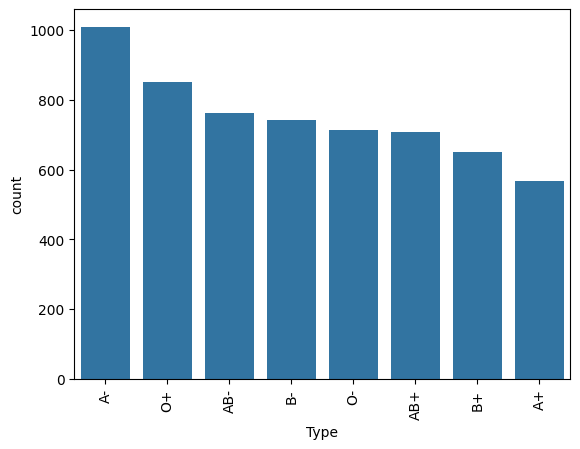

In [5]:
# Create a DataFrame with file paths and labels
filepath = pd.Series(filepaths, name='Filepath').astype(str)
Labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, Labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
print(data.head(5))

# Visualize class distribution
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)
plt.show()

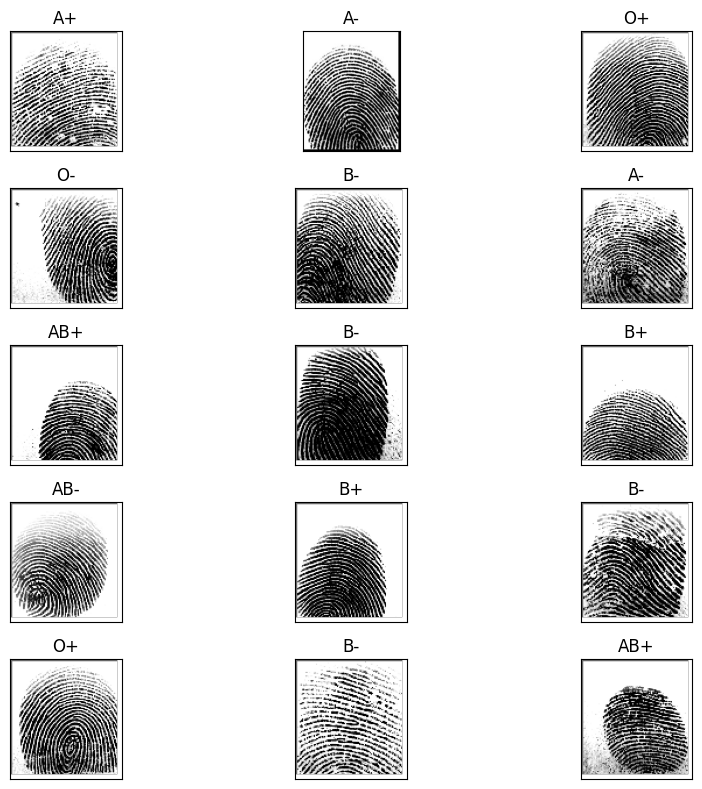

In [6]:
# Split data into training and testing sets
train, test = train_test_split(data, test_size=0.20, random_state=42)

# Visualize some images from the dataset
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [7]:
# Set up ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 4802 validated image filenames belonging to 8 classes.
Found 1201 validated image filenames belonging to 8 classes.


In [8]:
from tensorflow.keras.applications import VGG16

# Define the base pre-trained model
vgg16_base = VGG16(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

vgg16_base.trainable = False

# Add layers for classification on top of VGG16
x = Dense(128, activation="relu")(vgg16_base.output)
x = Dense(128, activation="relu")(x)
outputs = Dense(8, activation='softmax')(x)

vgg16_model = Model(inputs=vgg16_base.input, outputs=outputs)

vgg16_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = vgg16_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
)

c:\Users\yashm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.3560 - loss: 1.9475 - val_accuracy: 0.6103 - val_loss: 1.0771
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.6557 - loss: 0.8901 - val_accuracy: 0.6978 - val_loss: 0.7911
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.7407 - loss: 0.6833 - val_accuracy: 0.7027 - val_loss: 0.7978
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.7643 - loss: 0.5934 - val_accuracy: 0.7302 - val_loss: 0.7056
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.8088 - loss: 0.4882 - val_accuracy: 0.7402 - val_loss: 0.6923
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 479s 3s/step - accuracy: 0.8310 - loss: 0.4491 - val_accuracy: 0.7002 - val_loss: 0.7858
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4623s 31s/step - accuracy: 0.8501 - loss: 0.4142 - val_accuracy: 0.7336 - val_loss: 0.6769
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1235s 8s/step - accuracy: 0.8580 - loss: 0.3769 - val_a

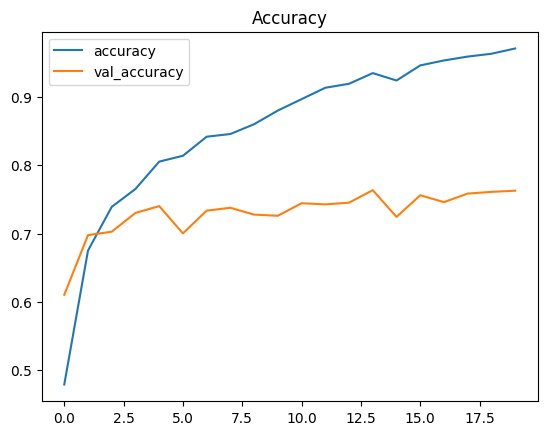

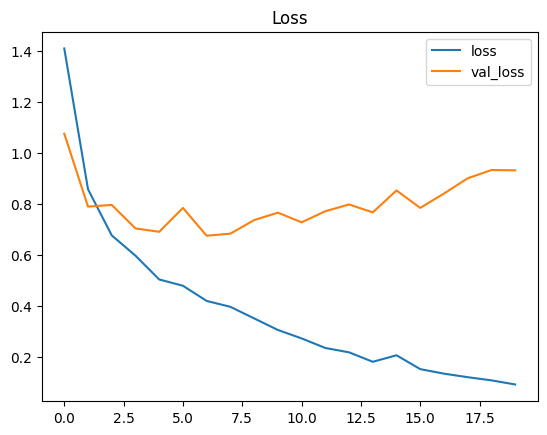

Test Loss: 0.93340
Test Accuracy: 76.27%
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step
              precision    recall  f1-score   support

          A+       0.83      0.76      0.80       113
          A-       0.76      0.75      0.76       201
         AB+       0.71      0.79      0.75       126
         AB-       0.73      0.84      0.78       160
          B+       0.73      0.64      0.68       128
          B-       0.91      0.91      0.91       167
          O+       0.68      0.78      0.73       164
          O-       0.77      0.58      0.66       142

    accuracy                           0.76      1201
   macro avg       0.77      0.76      0.76      1201
weighted avg       0.77      0.76      0.76      1201



In [9]:
# Plot training history: accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plot training history: loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

# Evaluate the model on test data
results = vgg16_model.evaluate(valid_gen, verbose=0)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")

# Predict labels for test data
pred = vgg16_model.predict(valid_gen)
pred = np.argmax(pred, axis=1)

# Map predicted labels
labels = train_gen.class_indices
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Compare predicted labels with true labels and print classification report
y_test = list(test.Label)
print(classification_report(y_test, pred))

In [12]:
vgg16_model.save("blood_group_detection.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


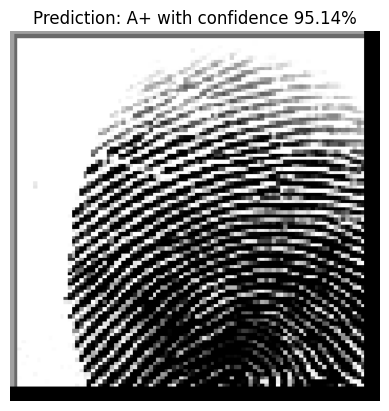

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Load the pre-trained model
model = load_model('model_blood_group_detection_vgg16.h5')

# Define the class labels
labels = {'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}
labels = dict((v, k) for k, v in labels.items())

# Example of loading a single image and making a prediction
img_path = '../../dataset/dataset_blood_group/A+/cluster_0_1001.BMP'

img = image.load_img(img_path, target_size=(256, 256))  # Load the image
x = image.img_to_array(img)  # Convert image to array
x = np.expand_dims(x, axis=0)  # Expand dimensions to match the model input
x = preprocess_input(x)  # Preprocess the image

result = model.predict(x)  # Predict using the model
predicted_class = np.argmax(result)  # Get the predicted class index

# Map the predicted class to the label
predicted_label = labels[predicted_class]
confidence = result[0][predicted_class] * 100  # Confidence level

# Display the image
plt.imshow(image.array_to_img(image.img_to_array(img) / 255.0))
plt.axis('off')  # Hide axes

# Display the prediction and confidence below the image
plt.title(f"Prediction: {predicted_label} with confidence {confidence:.2f}%")
plt.show()
